In [1]:
from rl4caribou import Caribou, CaribouScipy
from rl4caribou.agents import constAction

import numpy as np
import pandas as pd

from skopt import gp_minimize, gbrt_minimize
import ray

# Utility fns

In [2]:
env = CaribouScipy()

def ep_df(mortality_vec):
    agent = constAction(mortality_vec=mortality_vec)
    env = CaribouScipy()
    env.initial_pop  = [0.3, 0.15, 0.05]
    obs, _ =  env.reset()
    observs = []
    ep_rew = 0
    for t in range(800):
        action, info =  agent.predict(obs)
        observs.append([t, *(env.bound  * (obs+1))/2])
        obs, rew, term, trunc, info = env.step(action)
        ep_rew += rew
        if term or trunc:
            break
    
    data = pd.DataFrame(observs, columns=['t', 'M', 'B', 'W'])
    data['agent'] = str(pretty_vec(mortality_vec)) + f": rew = {ep_rew:.2f}"
    return data

def agent_ep_df(agent, agent_id="agent"):
    env = CaribouScipy()
    env.initial_pop  = [0.3, 0.15, 0.05]
    obs, _ =  env.reset()
    observs = []
    ep_rew = 0
    for t in range(800):
        action, info =  agent.predict(obs)
        observs.append([t, *(env.bound  * (obs+1))/2, *(action + 1)/2])
        obs, rew, term, trunc, info = env.step(action)
        ep_rew += rew
        if term or trunc:
            break
    
    data = pd.DataFrame(observs, columns=['t', 'M', 'B', 'W', 'MCull', 'WCull'])
    data['agent'] = agent_id + f": rew = {ep_rew:.2f}"
    return data

@ray.remote
def gen_ep_rew(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action, _ = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats(manager, env, N=150):
    results = ray.get([gen_ep_rew.remote(manager, env) for _ in range(N)])
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax 

def gen_ep_rew_seq(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action, _ = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats_seq(manager, env, N=100):
    results = [gen_ep_rew_seq(manager, env) for _ in range(N)]
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax 

def pretty_vec(vec):
    return [eval(f'{el:.3f}') for el in vec]

def g(x):
    manager = constAction(mortality_vec=x)
    out = gather_stats(manager, env)
    print(f"{pretty_vec(manager.mortality_vec)}, {out[0]:.3f}", end=27*" "+"\r")
    return - out[0]

# Optimal constant action

In [3]:
%%time
res = gp_minimize(g, [(0.0, 1.0), (0.0, 1.0)], n_calls = 100)
opt_mortality = res.x

res.x, - res.fun # g was negative to begin with in order to use minimize method

2024-03-01 23:46:59,972	INFO worker.py:1724 -- Started a local Ray instance.


CPU times: user 6min 1s, sys: 35min 52s, total: 41min 54s
Wall time: 2min 22s


([0.2846977692414673, 0.0], -76.8689655118643)

In [4]:
# -->([0.27950870095934127, 0.36956662640253096], -65.08941351454096)

In [5]:
gather_stats(manager=constAction(res.x), env=CaribouScipy())

(-100.45752996936659, -209.49536603548933, 8.580306096756132)

# RL Agents

In [6]:
from stable_baselines3 import PPO
from sb3_contrib import TQC

ppoAgent = PPO.load("../saved_agents/PPO-CaribouScipy-2.zip")
tqcAgent = TQC.load("../saved_agents/TQC-CaribouScipy-2.zip")

In [7]:
gather_stats_seq(manager=tqcAgent, env=CaribouScipy())

(-25.84146727008485, -86.69016972646938, 35.00723518629968)

In [8]:
gather_stats_seq(manager=ppoAgent, env=CaribouScipy())

(12.992667277262091, -24.196096418426436, 50.18143097295062)

# Comparison episode

In [9]:
ppo_df = agent_ep_df(agent=ppoAgent, agent_id="PPO")
tqc_df = agent_ep_df(agent=tqcAgent, agent_id="TQC")
cact_df = agent_ep_df(agent=constAction(opt_mortality), agent_id="ConstAct")

In [10]:
# quick n dirty

ppo_acts = ppo_df.copy()[['t', 'MCull', 'WCull', 'agent']]
tqc_acts = tqc_df.copy()[['t', 'MCull', 'WCull', 'agent']]
cact_acts = cact_df.copy()[['t', 'MCull', 'WCull', 'agent']]

ppo_acts['data'] = 'action'
tqc_acts['data'] = 'action'
cact_acts['data'] = 'action'

ppo_pops = ppo_df.copy()[['t', 'M', 'B', 'W', 'agent']]
tqc_pops = tqc_df.copy()[['t', 'M', 'B', 'W', 'agent']]
cact_pops = cact_df.copy()[['t', 'M', 'B', 'W', 'agent']]

ppo_pops['data'] = 'population'
tqc_pops['data'] = 'population'
cact_pops['data'] = 'population'

In [11]:
df = pd.concat([ppo_acts, tqc_acts, cact_acts, ppo_pops, tqc_pops, cact_pops], ignore_index=True).melt(id_vars = ['t', 'agent', 'data'])

/opt/venv/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 2400 rows containing missing values.


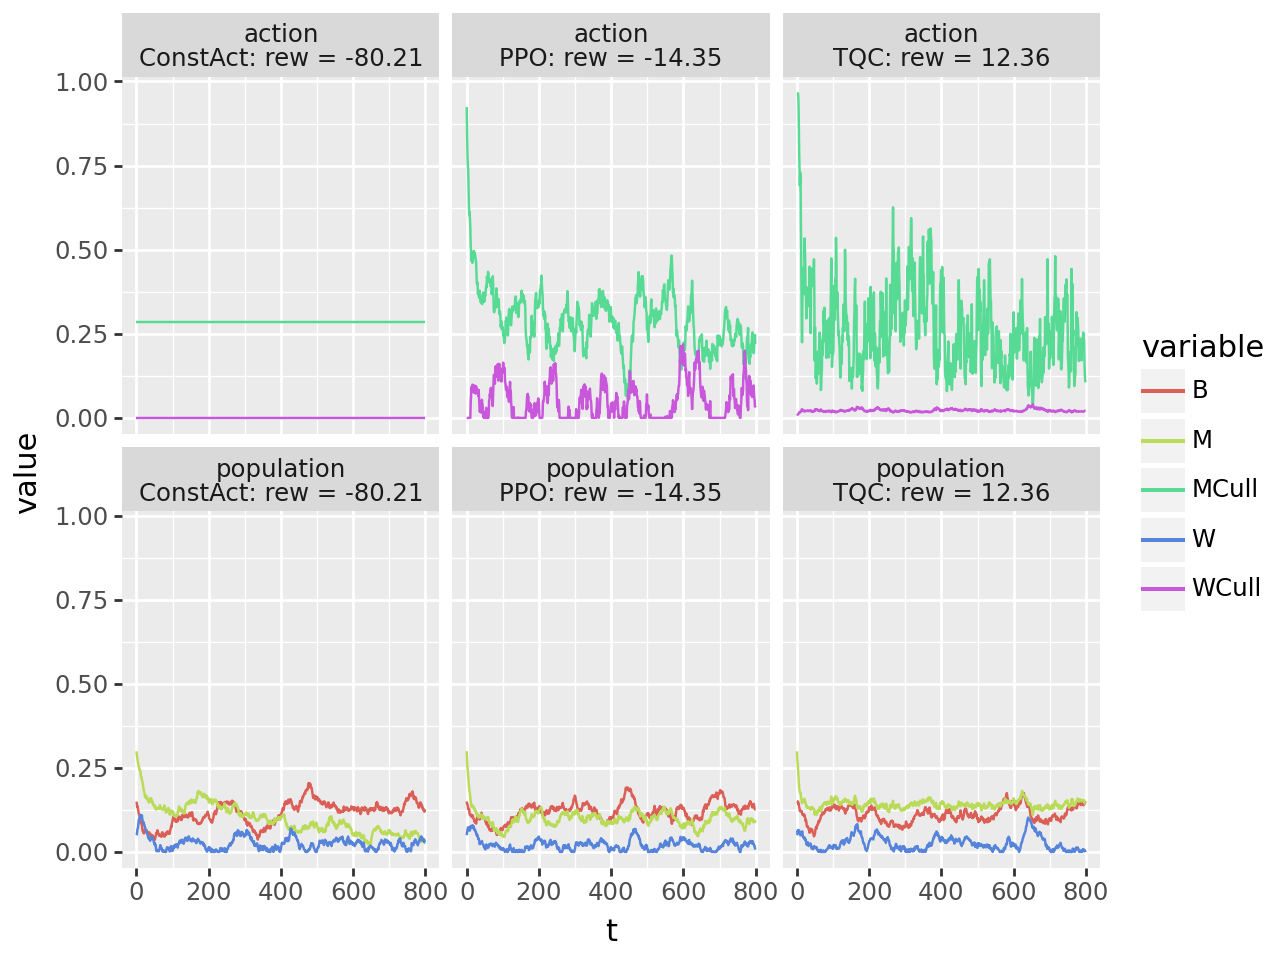

In [12]:
from plotnine import ggplot, aes, geom_line, facet_wrap
ggplot(df, aes(x='t', y='value', color='variable')) + geom_line() + facet_wrap(facets=['data', 'agent'], scales="Free")

# Violin plots

In [13]:
from tqdm import tqdm

tqc_rews = [gen_ep_rew_seq(tqcAgent, CaribouScipy()) for _ in tqdm(range(100))]
ppo_rews = [gen_ep_rew_seq(ppoAgent, CaribouScipy()) for _ in tqdm(range(100))]
cact_rews = ray.get([gen_ep_rew.remote(constAction([0.27950870095934127, 0.36956662640253096]), CaribouScipy()) for _ in range(100)])

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [14]:
df = pd.DataFrame(
    {
        'PPO': ppo_rews,
        'TQC': tqc_rews,
        'ConstAct': cact_rews,
    }
).melt()
df.head()

,variable,value
0,PPO,17.579274
1,PPO,45.429022
2,PPO,27.055361
3,PPO,52.908584
4,PPO,50.532980


In [15]:
# import seaborn as sns
# sns.violinplot(df, x="value", y="variable")

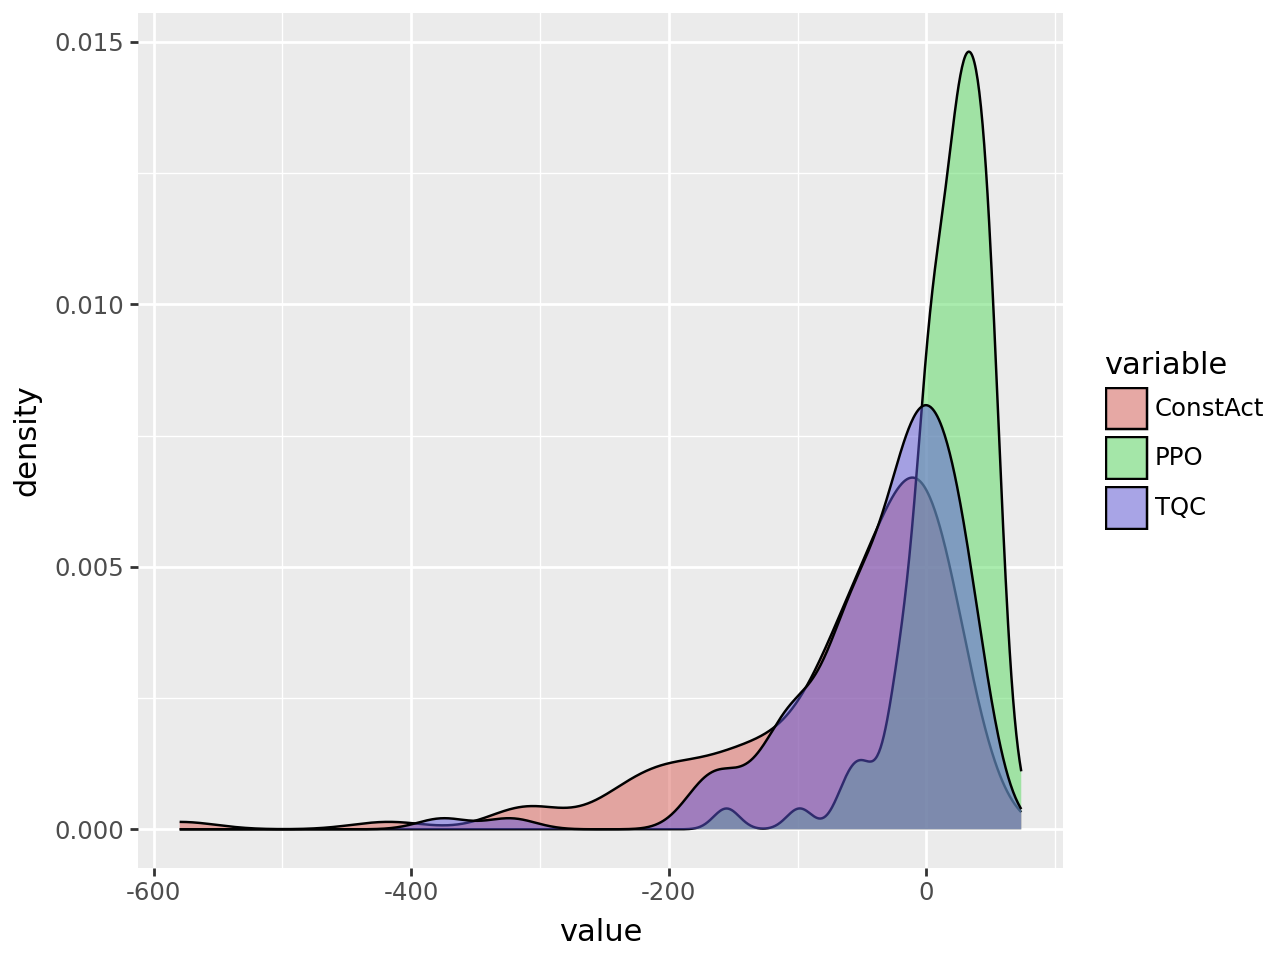

In [16]:
from plotnine import ggplot, aes, geom_density
(
    ggplot(df, aes(x="value", fill="variable")) +#  geom_bar(stat="bin", binwidth=1, alpha=0.5) + 
    geom_density(alpha=0.5) 
)